# Tree direction test (Heavy)

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import tree_test_utilities.flu_trees_statistics_calculator as flu_trees_statistics_calculator
import tree_test_utilities.tree_test_utilities as tree_test_utilities
import likelihood_calculator.likelihood_calculator as likelihood_calculator
import shm_kmer_model.shm_kmer_model as shm_kmer_model

In [4]:
flu_calc = flu_trees_statistics_calculator.FluTreesStatisticsCalculator()
tester = tree_test_utilities.TreeTester(minimal_size_filtered_tree=15)

In [5]:
# mutability_results_igh   = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGH', model_mode=shm_kmer_model.ModelMode.Mutation)
# substitution_results_igh = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGH', model_mode=shm_kmer_model.ModelMode.Substitution)
mut_subst_results_igh    = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGH', model_mode=shm_kmer_model.ModelMode.Both)

In [6]:
#print(mutability_results['Yale']['NoKNeighbours'][30][0])
#print(substitution_results['Yale']['NoKNeighbours'][30][0])
print(mut_subst_results_igh['Yale']['NoKNeighbours'][30][0])

(-6.52284360656108, -6.404290161054302)


In [7]:
(-5.02709596677701, -5.133498545651392)
(-1.49574763978407, -1.2707916154029102)
(-6.52284360656108, -6.404290161054302)

(-6.52284360656108, -6.404290161054302)

In [8]:
accuracy    = np.vectorize(lambda x: x[0] < x[1])
logloss     = np.vectorize(lambda x: x[0] - np.log(np.exp(x[0]) + np.exp(x[1])))
reliability = np.vectorize(lambda x: np.exp(x[0] - x[1]))

def apply_statistic_to_dataset(dataset, statistic, aggregate):
    results = []
    for tree in dataset:
        if len(tree):
            results.append(aggregate(statistic(tree)))
    return np.array(results)

def draw_classification_stats_distplot(x1, x2, bins=10):
    draw_distplot = (lambda x: sns.distplot(x[~np.isnan(x)], bins=bins, rug=True, kde=True))
    draw_distplot(x1)
    draw_distplot(x2)

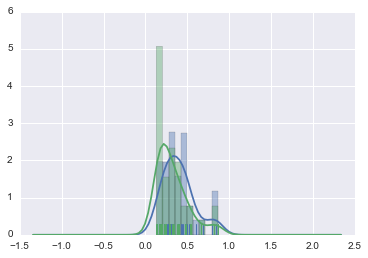

In [9]:
accuracy_yale = apply_statistic_to_dataset(mut_subst_results_igh['Yale']['Trivial'], accuracy, np.mean)
accuracy_cab  = apply_statistic_to_dataset(mut_subst_results_igh['CAB_NoKNeighbours']['Trivial'], accuracy, np.mean)
draw_classification_stats_distplot(accuracy_yale, accuracy_cab)

In [10]:
import scipy as sp
sp.stats.mannwhitneyu(accuracy_yale, accuracy_cab, use_continuity=True)

MannwhitneyuResult(statistic=787.0, pvalue=0.040943059618458622)

In [11]:
print(np.median(accuracy_yale), np.median(accuracy_cab))
print(np.mean(accuracy_yale), np.mean(accuracy_cab))

(0.38461538461538464, 0.27777777777777779)
(0.40091384252653522, 0.32470252664578819)


In [12]:
x = apply_statistic_to_dataset(mut_subst_results_igh['CAB_NoKNeighbours']['Trivial'], accuracy, lambda x: x)
np.mean(np.concatenate(x))

0.2899746192893401

In [13]:
x = apply_statistic_to_dataset(mut_subst_results_igh['Yale']['Trivial'], accuracy, lambda x: x)
np.mean(np.concatenate(x))

0.4016497461928934

-1201.13918617
-931.115785915


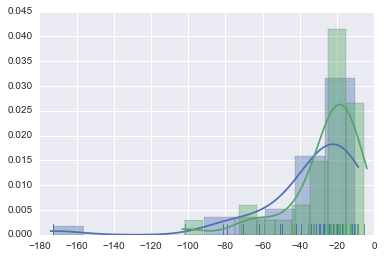

In [14]:
logloss_yale = apply_statistic_to_dataset(mut_subst_results_igh['Yale']['Trivial'], logloss, np.sum)
logloss_cab  = apply_statistic_to_dataset(mut_subst_results_igh['CAB_NoKNeighbours']['Trivial'], logloss, np.nansum)
draw_classification_stats_distplot(logloss_yale, logloss_cab)
print(np.sum(logloss_yale))
print(np.sum(logloss_cab))

In [15]:
sp.stats.mannwhitneyu(logloss_yale, logloss_cab, use_continuity=True)

MannwhitneyuResult(statistic=498.0, pvalue=0.18055292895708219)

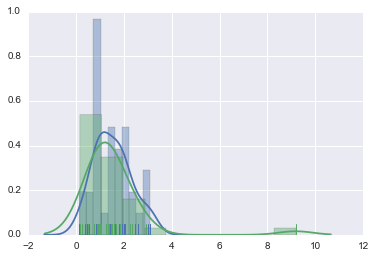

In [16]:
reliability_yale = apply_statistic_to_dataset(mut_subst_results_igh['Yale']['Trivial'], reliability, np.median)
reliability_cab  = apply_statistic_to_dataset(mut_subst_results_igh['CAB_NoKNeighbours']['Trivial'], reliability, np.nanmedian)
reliability_yale
draw_classification_stats_distplot(reliability_yale, reliability_cab)

In [17]:
sp.stats.mannwhitneyu(reliability_yale, reliability_cab, use_continuity=True)

MannwhitneyuResult(statistic=689.0, pvalue=0.37045025756825478)

In [18]:
np.median(reliability_yale)

1.4504645824287379

In [19]:
np.median(reliability_cab)

1.2527441537103976

# Tree direction test (Kappa)

In [20]:
import shm_kmer_model_estimator.standard_model_estimations as standard_model_estimations

In [21]:
flu_calc = flu_trees_statistics_calculator.FluTreesStatisticsCalculator(
    cab_model=standard_model_estimations.full_all_chains_model())

In [22]:
# mutability_results_igk   = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGK', model_mode=shm_kmer_model.ModelMode.Mutation)
# substitution_results_igk = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGK', model_mode=shm_kmer_model.ModelMode.Substitution)
mut_subst_results_igk    = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGK', model_mode=shm_kmer_model.ModelMode.Both)

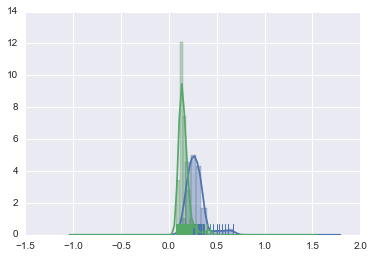

In [30]:
accuracy_yale = apply_statistic_to_dataset(mut_subst_results_igk['Yale']['Trivial'], accuracy, np.mean)
accuracy_cab  = apply_statistic_to_dataset(mut_subst_results_igk['CAB_NoKNeighbours']['Trivial'], accuracy, np.mean)
draw_classification_stats_distplot(accuracy_yale, accuracy_cab)

In [31]:
sp.stats.mannwhitneyu(accuracy_yale, accuracy_cab, use_continuity=True)

MannwhitneyuResult(statistic=18034.0, pvalue=5.5088202621955011e-34)

In [29]:
print(np.median(accuracy_yale), np.median(accuracy_cab))
print(np.mean(accuracy_yale), np.mean(accuracy_cab))

(0.26601930678017638, 0.14046144571710417)
(0.28130417780312117, 0.1548435247216795)


In [37]:
x = apply_statistic_to_dataset(mut_subst_results_igk['CAB_NoKNeighbours']['Trivial'], accuracy, lambda x: x)
np.mean(np.concatenate(x))

0.15421472937000888

In [38]:
x = apply_statistic_to_dataset(mut_subst_results_igk['Yale']['Trivial'], accuracy, lambda x: x)
np.mean(np.concatenate(x))

0.27537076942578276

-25453.7625211
-17353.2166438


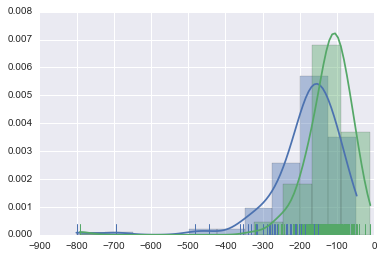

In [24]:
logloss_yale = apply_statistic_to_dataset(mut_subst_results_igk['Yale']['Trivial'], logloss, np.sum)
logloss_cab  = apply_statistic_to_dataset(mut_subst_results_igk['CAB_NoKNeighbours']['Trivial'], logloss, np.nansum)
draw_classification_stats_distplot(logloss_yale, logloss_cab)
print(np.sum(logloss_yale))
print(np.sum(logloss_cab))

In [32]:
sp.stats.mannwhitneyu(logloss_yale, logloss_cab, use_continuity=True)

MannwhitneyuResult(statistic=6341.0, pvalue=3.3076447532196856e-07)

# Tree direction test (Lambda)

In [25]:
# mutability_results_lambda   = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGL', model_mode=shm_kmer_model.ModelMode.Mutation)
# substitution_results_lambda = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGL', model_mode=shm_kmer_model.ModelMode.Substitution)
mut_subst_results_lambda    = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGL', model_mode=shm_kmer_model.ModelMode.Both)

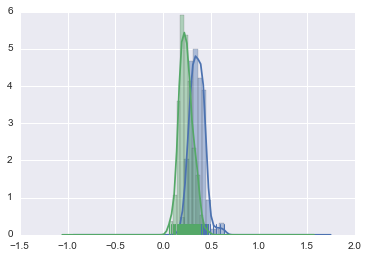

In [33]:
accuracy_yale = apply_statistic_to_dataset(mut_subst_results_lambda['Yale']['Trivial'], accuracy, np.mean)
accuracy_cab  = apply_statistic_to_dataset(mut_subst_results_lambda['CAB_NoKNeighbours']['Trivial'], accuracy, np.mean)
draw_classification_stats_distplot(accuracy_yale, accuracy_cab)

In [34]:
sp.stats.mannwhitneyu(accuracy_yale, accuracy_cab, use_continuity=True)

MannwhitneyuResult(statistic=17141.0, pvalue=2.3448427166413966e-27)

In [35]:
print(np.median(accuracy_yale), np.median(accuracy_cab))
print(np.mean(accuracy_yale), np.mean(accuracy_cab))

(0.35179526355996948, 0.23088169140800718)
(0.35428306739076337, 0.23753169878571997)


In [41]:
x = apply_statistic_to_dataset(mut_subst_results_lambda['CAB_NoKNeighbours']['Trivial'], accuracy, lambda x: x)
np.mean(np.concatenate(x))

0.23937205906214507

In [42]:
x = apply_statistic_to_dataset(mut_subst_results_lambda['Yale']['Trivial'], accuracy, lambda x: x)
np.mean(np.concatenate(x))

0.35453512899561901

-17837.5674472
-13108.0450309


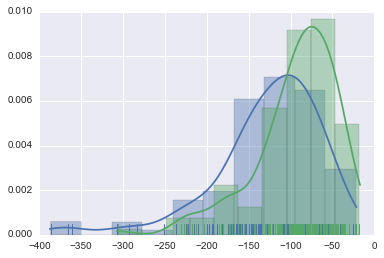

In [27]:
logloss_yale = apply_statistic_to_dataset(mut_subst_results_lambda['Yale']['Trivial'], logloss, np.sum)
logloss_cab  = apply_statistic_to_dataset(mut_subst_results_lambda['CAB_NoKNeighbours']['Trivial'], logloss, np.nansum)
draw_classification_stats_distplot(logloss_yale, logloss_cab)
print(np.sum(logloss_yale))
print(np.sum(logloss_cab))

In [36]:
sp.stats.mannwhitneyu(logloss_yale, logloss_cab, use_continuity=True)

MannwhitneyuResult(statistic=6341.0, pvalue=3.3076447532196856e-07)

# Germline test (Leukemia, IGH)

In [ ]:
import germline_test_utilities.germline_test_utilities as germline_test_utilities
import shm_kmer_model_estimator.standard_model_estimations as standard_model_estimations 

In [ ]:
tester = germline_test_utilities.GermlineTester()
cab_nokn_igh = standard_model_estimations.full_igh_model()
cab_nokn_igh = cab_nokn_igh['NoKNeighbours']['IGH']
yale_model = shm_kmer_model.YaleSHM_Model()

In [ ]:
cab_nokn_igh_lkhd = tester.get_likelihood_statistics(model=cab_nokn_igh)
yale_lkhd         = tester.get_likelihood_statistics(model=yale_model)

In [ ]:
cab_nokn_igh_accuracy = accuracy(cab_nokn_igh_lkhd)
yale_accuracy = accuracy(yale_lkhd)

In [ ]:
np.mean(cab_nokn_igh_accuracy)

In [ ]:
np.mean(accuracy_yale)

# Germline test (cross-validation)